# Exercício avaliativo

In [1]:
import io
import sqlite3
import pandas as pd

Neste exercício, vamos trabalhar com dados de uma empresa fictícia de consultoria.

**Considere o seguinte esquema relacional**:

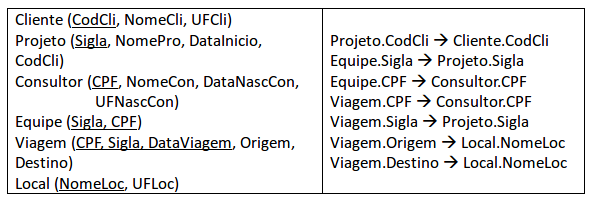

**assumindo as seguintes premissas**:

- Nenhum atributo admite valor nulo.
- Apenas as seguintes chaves primárias são numéricas: `Cliente.CodCli`, `Consultor.CPF`

# Download dos dados da empresa

In [2]:
!wget --no-check-certificate -P /tmp/ https://homepages.dcc.ufmg.br/~rodrygo/static/ibd/consultoria.sql

--2024-11-14 16:14:26--  https://homepages.dcc.ufmg.br/~rodrygo/static/ibd/consultoria.sql
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving homepages.dcc.ufmg.br (homepages.dcc.ufmg.br)... 150.164.0.136
Connecting to homepages.dcc.ufmg.br (homepages.dcc.ufmg.br)|150.164.0.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8832 (8.6K) [application/x-sql]
Saving to: ‘/tmp/consultoria.sql.5’

consultoria.sql.5   100%[===================>]   8.62K  --.-KB/s    in 0.007s  

2024-11-14 16:14:26 (1.29 MB/s) - ‘/tmp/consultoria.sql.5’ saved [8832/8832]



# Carregando o banco

In [6]:


conn = sqlite3.connect('/tmp/consultoria.db')

cursor = conn.cursor()

f = io.open('/tmp/consultoria.sql', 'r', encoding='utf-8')
sql = f.read()
cursor.executescript(sql)

# Consultas

Responda as perguntas abaixo através de consultas SQL no banco de dados carregado.

O formato da célula de resposta pode ser visto na resposta da consulta exemplo 0.

**Você pode usar mais de uma célula para responder, desde que a última célula antes da próxima consulta contenha a resposta final no formato mostrado no exemplo 0.**

## 0. [exemplo/não alterar]  Qual o nome e o número de viagens dos 5 consultores que mais viajaram a trabalho pela empresa IBD?

In [7]:
query = """
SELECT
  C.NomeCon as Nome, COUNT(C.CPF) as NViagens
FROM
  Consultor as C
INNER JOIN Viagem as V
  ON C.CPF = V.CPF
GROUP BY
  C.CPF
ORDER BY
  NViagens DESC
LIMIT 5
"""

df = pd.read_sql_query(query, conn)
df

Nome  NViagens
0    Melissa Carvalho Cunha         4
1    Rodrigo Araujo Cardoso         3
2  Larissa Fernandes Araujo         3
3    Diogo Cavalcanti Rocha         2
4     Lucas Fernandes Costa         1

## 1. Que consultores (CPF, nome e estado de nascimento) não nasceram em São Paulo (SP)?

In [8]:
pd.read_sql_query("""
SELECT
    C.CPF as CPF, C.NomeCon as Nome, C.UFNascCon as UF
FROM
    Consultor as C
WHERE
    UFNascCon <> 'SP'
""", conn)

CPF                       Nome  UF
0  13414263351      Samuel Araujo Azevedo  PR
1  71960563530     Diogo Cavalcanti Rocha  PB
2   3074973994       Julieta Maciel Sousa  RJ
3  29762035631          Caio Dias Ribeiro  MG
4  17787063122   Larissa Fernandes Araujo  MG
5  31266012516     Leonor Goncalves Rocha  MG
6  85726311353  Brenda Oliveira Goncalves  TO

## 2. Que projetos (sigla e nome) não são do cliente "Facebook"?

In [9]:
pd.read_sql_query("""
SELECT
    P.NomePro as Nome, C.NomeCli as Nome
FROM
    Projeto as P
INNER JOIN Cliente as C
    ON P.CodCli = C.CodCli
WHERE
    C.NomeCli <> 'Facebook'
""", conn)

Nome    Nome
0  Neural Machine Translation (Chinês para Portug...   Baidu
1                        Otimização Sistema de Busca  Google
2                           Detecção de Spam (Gmail)  Google
3                              Detecção de Fake News  OpenAI
4                                   Self Driving Car  OpenAI
5                               Sistema de Pagamento   iFood
6                            Sistema de Recomendação   iFood
7                                 Detecção de Fraude  Nubank

## 3. Para que UFs viajaram os consultores que participam do projeto de sigla "RecSys"?

In [10]:
pd.read_sql_query("""
SELECT
    L.UFLoc as UF
FROM
    Viagem as V
INNER JOIN Local as L
    ON V.Destino = L.NomeLoc
WHERE
    V.Sigla = 'RecSys'
GROUP BY
    V.Destino

""", conn)

UF
0  MG
1  SP

## 4. Que projetos (sigla e nome) não têm equipe?

In [11]:
pd.read_sql_query("""
SELECT
    P.Sigla as Sigla, P.NomePro as Nome
FROM
    Projeto as P
WHERE NOT EXISTS (
    SELECT
        *
    FROM
        Equipe as E
    WHERE
        P.Sigla = E.Sigla
);
""", conn)

Sigla                         Nome
0  Search  Otimização Sistema de Busca
1    Fake        Detecção de Fake News
2     SDC             Self Driving Car

## 5. Que projetos (sigla e nome) não têm em sua equipe consultores nascidos antes de 1987?


In [12]:
pd.read_sql_query("""
SELECT
    P.Sigla as Sigla, P.NomePro as Nome
FROM
    Projeto as P
WHERE
    P.Sigla NOT IN 
    (
        SELECT
            P.Sigla
        FROM
            Projeto as P
        INNER JOIN Equipe as E
            ON P.Sigla = E.Sigla
        INNER JOIN Consultor as C
            ON E.CPF = C.CPF
        WHERE
            -- função YEAR não funciona
            CAST(SUBSTRING(C.DataNascCon,0,5) AS int) < 1987
        GROUP BY
            P.Sigla
    );

""", conn)

Sigla                                               Nome
0     NMT  Neural Machine Translation (Chinês para Portug...
1  Search                        Otimização Sistema de Busca
2    Spam                           Detecção de Spam (Gmail)
3    Fake                              Detecção de Fake News
4     SDC                                   Self Driving Car
5  RecSys                            Sistema de Recomendação
6      VR                            Hardware para Oculus VR
7   Fraud                                 Detecção de Fraude

## 6. Que consultores (CPF e nome) viajaram por seu estado natal (origem ou destino)?

In [13]:
pd.read_sql_query("""
SELECT
    C.CPF as CPF, C.NomeCon as Nome
FROM
    Consultor as C
INNER JOIN Viagem as V
    ON C.CPF = V.CPF
INNER JOIN Local as Lo
    ON V.Origem = Lo.NomeLoc
INNER JOIN Local as Ld
    ON V.Destino = Ld.NomeLoc
WHERE
    Lo.UFLoc = C.UFNascCon
    OR
    Ld.UFLoc = C.UFNascCon
GROUP BY
    C.NomeCon
""", conn)

CPF                      Nome
0  29762035631         Caio Dias Ribeiro
1  17787063122  Larissa Fernandes Araujo
2  62465487841     Lucas Fernandes Costa
3  44434353608    Melissa Carvalho Cunha
4  34646193892    Rodrigo Araujo Cardoso

## 7. Para que locais não houve nenhuma viagem?

In [14]:
# não ficou claro se a pergunta quer filtrar destinos, origens ou ambos.
# presumirei ambos
pd.read_sql_query("""
SELECT
    *
FROM
    Local
WHERE
    NomeLoc NOT IN
(
    SELECT
        Origem
    FROM
        Viagem
    GROUP BY
        Origem
    
    UNION
    
    SELECT
        Destino
    FROM
        Viagem
    GROUP BY
        Destino
);
""", conn)

NOMELOC UFLOC
0   Amazon    WA
1  Netflix    CA
2  Spotify    NY

## 8. Em que projetos (sigla e nome) foram realizadas viagens para a California (CA) desde o início de 2019?

In [15]:
pd.read_sql_query("""
SELECT
    P.Sigla as Sigla, P.NomePro as Nome
FROM
    Viagem as V
INNER JOIN Local as Ld
    ON V.Destino = Ld.NomeLoc
INNER JOIN Projeto as P
    ON V.Sigla = P.Sigla
WHERE
    -- função YEAR não funciona
    CAST(SUBSTRING(V.DataViagem,0,5) AS int) > 2018
    AND
    Ld.UFLoc = 'CA'
GROUP BY
    P.Sigla

""", conn)

Sigla                             Nome
0        VR          Hardware para Oculus VR
1  WhatsApp  Cliente desktop para o WhatsApp

## 9. Que consultores (CPF e nome) viajaram por um projeto de cuja equipe não fazem parte?

In [16]:
pd.read_sql_query("""
SELECT
    CV.CPF as CPF, CV.NomeCon as Nome
FROM
    Viagem as V
INNER JOIN Projeto as P
    ON V.Sigla = P.Sigla
INNER JOIN Consultor as CV
    ON V.CPF = CV.CPF
WHERE NOT EXISTS
(
    SELECT
        CE.CPF as CPF, E.Sigla as Sigla
    FROM
        Consultor as CE
    INNER JOIN Equipe as E
        ON CE.CPF = E.CPF
    WHERE
        CE.CPF = CV.CPF
        AND
        E.Sigla = P.Sigla
);
""", conn)

CPF                    Nome
0  34646193892  Rodrigo Araujo Cardoso
1  44434353608  Melissa Carvalho Cunha

## 10. Que consultores (CPF e nome) não estão em nenhuma equipe de projeto que tenha iniciado em 2019?


In [17]:
pd.read_sql_query("""
SELECT
    C.CPF as CPF, C.NomeCon as Nome
FROM
    Consultor as C
WHERE
    C.CPF NOT IN
(
    SELECT
        E.CPF
    FROM
        Projeto as P
    INNER JOIN Equipe as E
        ON P.Sigla = E.Sigla
    WHERE
        -- por algum motivo a função YEAR não funcionou aqui
        SUBSTRING(P.DataInicio,0,5) = '2019'
);
""", conn)

CPF                       Nome
0  13414263351      Samuel Araujo Azevedo
1  71960563530     Diogo Cavalcanti Rocha
2  44434353608     Melissa Carvalho Cunha
3  62465487841      Lucas Fernandes Costa
4   3074973994       Julieta Maciel Sousa
5  29762035631          Caio Dias Ribeiro
6  34646193892     Rodrigo Araujo Cardoso
7  17787063122   Larissa Fernandes Araujo
8  31266012516     Leonor Goncalves Rocha
9  85726311353  Brenda Oliveira Goncalves